In [2]:
import pandas as pd
import numpy as np
import os

# ==============================================================================
# 1. 설정 및 데이터 로드
# ==============================================================================
PATH_SCORE = './FlowScore/'
PATH_POINT = './FlowPoint/'

def load_csv(folder, filename):
    path = os.path.join(folder, filename)
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            df.columns = [c.strip() for c in df.columns]
            return df
        except: return pd.DataFrame()
    return pd.DataFrame()

print("🚀 [수정] FlowScore 3.0: 승인 기업 모니터링 대시보드 재생성 (부채비율 포함)...")

# 데이터 로드
df_fin = load_csv(PATH_SCORE, 'company_financial_statement.csv')
df_inc = load_csv(PATH_SCORE, 'company_income_statement.csv')
df_comp = load_csv(PATH_SCORE, 'company.csv')
df_rcv_trans = load_csv(PATH_POINT, 'receivable_transactions.csv')
df_trans = load_csv(PATH_POINT, 'transactions.csv')
df_receiv = load_csv(PATH_POINT, 'receivables.csv')
df_ceo = load_csv(PATH_POINT, 'pay_bnpl_customer_infos_b2c.csv')
df_css = load_csv(PATH_POINT, 'business_css_infos.csv')

# ==============================================================================
# 2. 지표 산출
# ==============================================================================
dashboard_data = {}

# (1) 재무 지표
if not df_fin.empty:
    df_fin['fs_acct_dt'] = pd.to_datetime(df_fin['fs_acct_dt'])
    fin_latest = df_fin.sort_values('fs_acct_dt').groupby('company_id').tail(1).set_index('company_id')
    for cid, row in fin_latest.iterrows():
        curr_ratio = row.get('fs_val2', 0) / row.get('fs_val238', 1) if row.get('fs_val238', 0) > 0 else 0
        debt_ratio = row.get('fs_val237', 0) / row.get('fs_val317', 1) * 100 if row.get('fs_val317', 0) > 0 else 0
        
        dashboard_data.setdefault(cid, {})['Current_Ratio'] = curr_ratio
        dashboard_data[cid]['Debt_Ratio'] = debt_ratio

# (2) 활동 지표 (오후 결제)
if not df_rcv_trans.empty:
    df_rcv_trans['created_at'] = pd.to_datetime(df_rcv_trans['created_at'])
    df_rcv_trans['hour'] = df_rcv_trans['created_at'].dt.hour
    cid_col = 'company_id' if 'company_id' in df_rcv_trans.columns else ('company_id_tx' if 'company_id_tx' in df_rcv_trans.columns else None)
    if cid_col:
        tx_stats = df_rcv_trans.groupby(cid_col).agg(total=('id', 'count'), late=('hour', lambda x: (x >= 16).sum()))
        tx_stats['Late_Pay_Ratio'] = tx_stats['late'] / tx_stats['total']
        for cid, row in tx_stats.iterrows():
            dashboard_data.setdefault(cid, {})['Late_Pay_Ratio'] = row['Late_Pay_Ratio']
            dashboard_data[cid]['Tx_Count'] = row['total']

# (3) 활동 지표 (지연 일수)
if not df_trans.empty and not df_receiv.empty:
    if 'receivable_id' in df_trans.columns and 'id' in df_receiv.columns:
        df_receiv['due_date'] = pd.to_datetime(df_receiv['due_date'])
        df_trans['created_at'] = pd.to_datetime(df_trans['created_at'])
        merged = pd.merge(df_trans, df_receiv, left_on='receivable_id', right_on='id', suffixes=('_tx', '_rcv'))
        
        pay_date = 'created_at_tx' if 'created_at_tx' in merged.columns else 'created_at'
        due_date = 'due_date_rcv' if 'due_date_rcv' in merged.columns else 'due_date'
        
        if pay_date in merged.columns and due_date in merged.columns:
            merged['delay_days'] = (merged[pay_date] - merged[due_date]).dt.days
            comp_col = 'company_id_rcv' if 'company_id_rcv' in merged.columns else 'company_id'
            if comp_col in merged.columns:
                delay_stats = merged.groupby(comp_col)['delay_days'].mean()
                for cid, delay in delay_stats.items():
                    dashboard_data.setdefault(cid, {})['Avg_Delay_Days'] = delay

# (4) 신용 지표
if not df_css.empty and 'total_score' in df_css.columns:
    for _, row in df_css.iterrows():
        if pd.notnull(row.get('company_id')):
            dashboard_data.setdefault(row['company_id'], {})['Biz_Score'] = row['total_score']

if not df_ceo.empty and 'credit_score' in df_ceo.columns and 'company_id' in df_ceo.columns:
    for _, row in df_ceo.iterrows():
        if pd.notnull(row.get('company_id')):
            dashboard_data.setdefault(row['company_id'], {})['CEO_Score'] = row['credit_score']

# ==============================================================================
# 3. 리포트 생성 및 저장
# ==============================================================================
results = []
for cid, metrics in dashboard_data.items():
    comp_name = f"ID {cid}"
    if not df_comp.empty:
        match = df_comp[df_comp['id'] == cid]['company_name']
        if not match.empty: comp_name = match.values[0]
    
    # 리스크 판정
    alerts = []
    cr = metrics.get('Current_Ratio', 99)
    dr = metrics.get('Debt_Ratio', 0)
    lpr = metrics.get('Late_Pay_Ratio', 0)
    delay = metrics.get('Avg_Delay_Days', 0)
    biz = metrics.get('Biz_Score', 0)
    ceo = metrics.get('CEO_Score', 0)

    if cr <= 1.0 and 'Current_Ratio' in metrics: alerts.append("유동성주의")
    if dr >= 300: alerts.append("부채과다")
    if lpr >= 0.2: alerts.append(f"오후결제({lpr*100:.0f}%)")
    if delay >= 5: alerts.append(f"결제지연({delay:.1f}일)")
    if 0 < biz < 50: alerts.append("기업신용저하")
    if 0 < ceo < 700: alerts.append("CEO신용저하")

    risk_cnt = len(alerts)
    if risk_cnt == 0: grade = 'Normal'
    elif risk_cnt == 1: grade = 'Watch'
    elif risk_cnt == 2: grade = 'Warning'
    else: grade = 'Danger'

    row = {
        'Company_ID': cid,
        'Company_Name': comp_name,
        'Grade': grade,
        'Risk_Signals': ", ".join(alerts) if alerts else "-",
        'Late_Pay_Ratio': f"{lpr*100:.1f}%" if 'Late_Pay_Ratio' in metrics else "-",
        'Avg_Delay_Days': f"{delay:.1f}일" if 'Avg_Delay_Days' in metrics else "-",
        'Current_Ratio': f"{cr:.2f}" if 'Current_Ratio' in metrics else "-",
        'Debt_Ratio': f"{dr:.1f}%" if 'Debt_Ratio' in metrics else "-",  # <--- [중요] 누락되었던 부채비율 추가
        'Biz_Score': biz if 'Biz_Score' in metrics else "-",
        'CEO_Score': ceo if 'CEO_Score' in metrics else "-",
        'Tx_Count': metrics.get('Tx_Count', 0)
    }
    results.append(row)

df_report = pd.DataFrame(results)

if not df_report.empty:
    df_report['Risk_Weight'] = df_report['Grade'].map({'Danger': 3, 'Warning': 2, 'Watch': 1, 'Normal': 0})
    df_report = df_report.sort_values('Risk_Weight', ascending=False).drop(columns='Risk_Weight')
    
    print(f"\n✅ [수정 완료] 총 {len(df_report)}개 기업 리포트 생성 (부채비율 포함)")
    print(df_report[['Company_Name', 'Grade', 'Current_Ratio', 'Debt_Ratio']].head()) # 확인용 출력
    df_report.to_csv('FlowScore_3.0_Monitoring_Report.csv', index=False, encoding='utf-8-sig')
    print("📁 결과 파일 저장됨: FlowScore_3.0_Monitoring_Report.csv")
else:
    print("❌ 데이터가 없어 리포트를 생성하지 못했습니다.")

🚀 [수정] FlowScore 3.0: 승인 기업 모니터링 대시보드 재생성 (부채비율 포함)...

✅ [수정 완료] 총 846개 기업 리포트 생성 (부채비율 포함)
    Company_Name   Grade Current_Ratio Debt_Ratio
477        (주)문무  Danger          1.13     423.6%
452   한국에이스산업(주)  Danger          0.62     201.8%
577     (주)티웨이항공  Danger          0.75    1970.8%
579     덴소코리아(주)  Danger          0.81     275.6%
281      (주)부루구루  Danger          0.75    1737.3%
📁 결과 파일 저장됨: FlowScore_3.0_Monitoring_Report.csv


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os

# ==============================================================================
# 1. 설정 및 시드 데이터 로드
# ==============================================================================
SEED_FILE = 'FlowScore_3.0_Monitoring_Report.csv'
OUTPUT_FILE = 'Synthetic_Rejected_Dataset_Advanced.csv'
N_SAMPLES = 1000 # 생성할 거절 데이터 수

if not os.path.exists(SEED_FILE):
    print(f"❌ '{SEED_FILE}' 파일이 없습니다. 이전 단계 코드를 먼저 실행해주세요.")
    exit()

df_seed = pd.read_csv(SEED_FILE)

# 데이터 전처리: 수치형 변환 및 결측치 처리
def clean_numeric(x):
    if isinstance(x, str):
        return float(x.replace('%', '').replace('일', '').replace(',', '').replace('-', '0'))
    return float(x) if pd.notnull(x) else 0

numeric_cols = ['Current_Ratio', 'Debt_Ratio', 'Late_Pay_Ratio', 'Avg_Delay_Days', 'Biz_Score', 'CEO_Score']
for col in numeric_cols:
    df_seed[col] = df_seed[col].apply(clean_numeric)

# 시드 데이터의 통계적 특성 파악 (Natural Noise 주입용)
stats_dict = df_seed[numeric_cols].describe().to_dict()

print(f"🚀 [Advanced] 합성 데이터 생성 시작 (Seed: {len(df_seed)}개 기업)")

# ==============================================================================
# 2. 전략 구현 함수 (Strategies Implementation)
# ==============================================================================

# [전략 1 & 2] 절단 정규분포(Truncated Normal) 및 자연 노이즈 주입
def get_truncated_normal(mean, sd, low, upp):
    return stats.truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs()

def apply_financial_distress(row):
    """
    시나리오 A: 재무 상태 악화 (Financial Distress)
    - 유동비율: 1.0 미만으로 하락 (Truncated Normal 사용)
    - 부채비율: 300% 이상으로 급등
    """
    new_row = row.copy()
    
    # 유동비율 악화: 평균 0.7, 표준편차 0.2, 범위 0.3~0.95
    new_row['Current_Ratio'] = round(get_truncated_normal(0.7, 0.2, 0.3, 0.95), 2)
    
    # 부채비율 악화: 평균 500%, 표준편차 100, 범위 300%~2000%
    new_row['Debt_Ratio'] = round(get_truncated_normal(500, 100, 300, 2000), 1)
    
    # Reject Reason
    new_row['Reject_Reason'] = 'Financial_Distress'
    return new_row

def apply_liquidity_crunch(row):
    """
    시나리오 B: 자금 경색 (Liquidity Crunch) - 활동성 지표 악화
    - 오후 결제 비율: 40% 이상으로 증가
    - 결제 지연일: 15일 이상으로 증가
    """
    new_row = row.copy()
    
    # 오후 결제 악화: 평균 0.6(60%), 범위 0.4~1.0
    new_row['Late_Pay_Ratio'] = round(get_truncated_normal(0.6, 0.15, 0.4, 1.0), 3)
    
    # 결제 지연 악화: 평균 45일, 범위 15일~120일
    new_row['Avg_Delay_Days'] = round(get_truncated_normal(45, 15, 15, 120), 1)
    
    new_row['Reject_Reason'] = 'Liquidity_Crunch'
    return new_row

def apply_credit_risk(row):
    """
    시나리오 C: 신용 위험 (Credit Risk)
    - 기업 등급 및 CEO 신용 점수 동반 하락
    """
    new_row = row.copy()
    
    # 기업 점수 하락: 10~50점 사이
    new_row['Biz_Score'] = int(get_truncated_normal(30, 10, 10, 50))
    
    # CEO 점수 하락: 300~650점 사이
    new_row['CEO_Score'] = int(get_truncated_normal(500, 80, 300, 650))
    
    new_row['Reject_Reason'] = 'Credit_Risk'
    return new_row

# [전략 3] 변수 간 인과 관계(Causal Dependency) 적용
def apply_dependency_logic(row):
    """
    데이터 정합성을 위한 인과 관계 조정
    - 부채비율이 폭등하면 -> 기업 신용점수(Biz_Score)도 자연스럽게 하락해야 함
    - 결제 지연이 길어지면 -> 유동비율도 낮을 가능성이 큼
    """
    # Rule 1: 부채비율이 400% 넘으면 Biz_Score는 60점을 넘을 수 없음
    if row['Debt_Ratio'] > 400:
        row['Biz_Score'] = min(row['Biz_Score'], np.random.randint(20, 60))
        
    # Rule 2: 결제 지연이 30일 넘으면 CEO 신용도 타격 (연체 공유 가정)
    if row['Avg_Delay_Days'] > 30:
        row['CEO_Score'] = min(row['CEO_Score'], np.random.randint(400, 700))
        
    return row

# [전략 4] 자연스러운 노이즈 주입 (Natural Noise Injection)
def inject_natural_noise(row):
    """
    거절 사유와 무관한 변수에도 약간의 변동을 주어 데이터 다양성 확보
    (Lognormal 분포와 유사한 효과)
    """
    # 관련 없는 컬럼들에 대해 ±5% 랜덤 변동
    for col in ['Tx_Count']: # 거래 횟수 등
        if col in row:
            noise = np.random.uniform(0.95, 1.05)
            row[col] = round(row[col] * noise, 0)
    return row

# ==============================================================================
# 3. 데이터 생성 루프
# ==============================================================================
generated_data = []

for i in range(N_SAMPLES):
    # 1. Seed 기업 랜덤 선택 (기존 승인 기업 중 하나 복제)
    seed_row = df_seed.sample(1).iloc[0].to_dict()
    
    # 2. 시나리오 랜덤 선택
    # 재무부실(35%), 자금경색(35%), 신용위험(20%), 복합부실(10%)
    scenario = np.random.choice(['FIN', 'LIQ', 'CREDIT', 'ALL'], p=[0.35, 0.35, 0.2, 0.1])
    
    new_row = seed_row.copy()
    new_row['Company_ID'] = 90000 + i  # 가상 ID 부여
    new_row['Company_Name'] = f"Synthetic_Reject_{i:04d}"
    new_row['Grade'] = 'Reject'
    
    # 3. 섭동(Perturbation) 적용
    if scenario == 'FIN':
        new_row = apply_financial_distress(new_row)
    elif scenario == 'LIQ':
        new_row = apply_liquidity_crunch(new_row)
    elif scenario == 'CREDIT':
        new_row = apply_credit_risk(new_row)
    elif scenario == 'ALL':
        new_row = apply_financial_distress(new_row)
        new_row = apply_liquidity_crunch(new_row) # 중첩 적용
        new_row['Reject_Reason'] = 'Combined_Risk'
        
    # 4. 인과 관계 및 노이즈 적용 (데이터 품질 향상)
    new_row = apply_dependency_logic(new_row)
    new_row = inject_natural_noise(new_row)
    
    generated_data.append(new_row)

# ==============================================================================
# 4. 결과 통합 및 저장
# ==============================================================================
df_synthetic = pd.DataFrame(generated_data)

# 승인 데이터(Real)와 병합
df_real = df_seed.copy()
df_real['Grade'] = 'Approve' # 기존 Danger 등급도 학습용으론 일단 분리하거나 제외 가능 (여기선 Approve로 통일)
df_real['Reject_Reason'] = 'None'

# 최종 데이터셋 구성
cols = ['Current_Ratio', 'Debt_Ratio', 'Late_Pay_Ratio', 'Avg_Delay_Days', 'Biz_Score', 'CEO_Score', 'Tx_Count', 'Grade', 'Reject_Reason']
df_final = pd.concat([df_real, df_synthetic], ignore_index=True)
# 필요한 컬럼만 유지 및 셔플
df_final = df_final[cols].sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ [합성 데이터 생성 완료]")
print(f" - 승인 데이터(Real): {len(df_real)}건")
print(f" - 거절 데이터(Synthetic): {len(df_synthetic)}건")
print(f" - 총 학습 데이터: {len(df_final)}건")

# 통계 확인
print("\n📊 [생성된 거절 데이터 통계 요약]")
print(df_synthetic[['Current_Ratio', 'Debt_Ratio', 'Late_Pay_Ratio', 'Avg_Delay_Days']].describe().loc[['mean', 'min', 'max']])

# 저장
df_final.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
print(f"\n📁 파일 저장됨: {OUTPUT_FILE}")

🚀 [Advanced] 합성 데이터 생성 시작 (Seed: 846개 기업)

✅ [합성 데이터 생성 완료]
 - 승인 데이터(Real): 846건
 - 거절 데이터(Synthetic): 1000건
 - 총 학습 데이터: 1846건

📊 [생성된 거절 데이터 통계 요약]
      Current_Ratio    Debt_Ratio  Late_Pay_Ratio  Avg_Delay_Days
mean        5.84374    562.346246        3.639117         38.0322
min         0.00000      0.000000        0.000000          0.0000
max      1970.14000  95805.700000      100.000000        766.4000

📁 파일 저장됨: Synthetic_Rejected_Dataset_Advanced.csv


In [3]:
pip install sdv

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
   ---------------------------------------- 0.0/14.5 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/14.5 MB 8.4 MB/s eta 0:00:02
   ------ --------------------------------- 2.4/14.5 MB 6.7 MB/s eta 0:00:02
   ------- -------------------------------- 2.9/14.5 MB 4.9 MB/s eta 0:00:03
   ----------- ---------------------------- 4.2/14.5 MB 4.7 MB/s eta 0:00:03
   ------------- -------------------------- 5.0/14.5 MB 4.7 MB/s eta 0:00:03
   ---------------- ----------------------- 6.0/14.5 MB 4.7 MB/s eta 0:00:02
   -------------------- ------------------- 7.6/14.5 MB 5.1 MB/s eta 0:00:02
   ------------------------ --------------- 8.9/14.5 MB 5.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install pandas numpy scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import os

# ==============================================================================
# [Section 1] 데이터 로드 및 시드(Seed) 데이터셋 구성
# ==============================================================================
print("🚀 [1단계] 데이터 로드 및 시드 데이터셋 구성 중...")

# 1. 파일 로드
df_base = pd.read_csv('FlowScore_3.0_Monitoring_Report.csv')
df_feat = pd.read_csv('Flow_Engineered_Features.csv')

# 2. 병합 (기초 체력 + 행동 패턴)
df_real = pd.merge(df_base, df_feat, on='Company_ID', how='inner')

# 3. 전처리 (숫자 변환 및 결측치 제거)
features = [
    'Current_Ratio', 'Debt_Ratio', 'Late_Pay_Ratio', 'Avg_Delay_Days', 'Biz_Score', 'CEO_Score',
    'Sales_Growth', 'OPM_Change', 'Rev_Per_Emp', 'Tx_Volatility', 'Weekend_Tx_Ratio', 'Avg_Tx_Hour', 'Emp_Momentum'
]

def clean_num(x):
    if isinstance(x, str): return float(x.replace('%','').replace('일','').replace(',','').replace('-','0'))
    return float(x) if pd.notnull(x) else 0

for col in features:
    df_real[col] = df_real[col].apply(clean_num)

# 4. CTGAN 학습용 '규칙 기반 거절 데이터(Rule-based Rejects)' 생성
# (이게 있어야 CTGAN이 부실 패턴을 배울 수 있음)
def generate_seed_rejects(n):
    data = []
    for _ in range(n):
        row = {}
        # 무작위 시나리오 (재무/활동/운영 부실)
        scenario = np.random.choice(['FIN', 'ACT', 'OPS'], p=[0.4, 0.4, 0.2])
        
        # 기본값 (랜덤)
        row['Current_Ratio'] = np.random.uniform(0.5, 1.2)
        row['Debt_Ratio'] = np.random.uniform(200, 500)
        row['Late_Pay_Ratio'] = np.random.uniform(0.1, 0.4)
        row['Avg_Delay_Days'] = np.random.uniform(0, 20)
        row['Biz_Score'] = np.random.randint(50, 70)
        row['CEO_Score'] = np.random.randint(600, 800)
        # 신규 변수 기본값
        row['Sales_Growth'] = np.random.uniform(-0.1, 0.1)
        row['OPM_Change'] = np.random.uniform(-0.05, 0.02)
        row['Rev_Per_Emp'] = np.random.uniform(50, 300)
        row['Tx_Volatility'] = np.random.uniform(0.2, 0.5)
        row['Weekend_Tx_Ratio'] = 0.0
        row['Avg_Tx_Hour'] = np.random.uniform(11, 15)
        row['Emp_Momentum'] = 0.0

        # 핵심 악화 로직 (Rule Injection)
        if scenario == 'FIN':
            row['Current_Ratio'] = np.random.uniform(0.3, 0.9)
            row['Debt_Ratio'] = np.random.uniform(400, 1000)
            row['Sales_Growth'] = np.random.uniform(-0.5, -0.1)
        elif scenario == 'ACT':
            row['Late_Pay_Ratio'] = np.random.uniform(0.4, 0.9)
            row['Avg_Delay_Days'] = np.random.uniform(30, 90)
            row['Avg_Tx_Hour'] = np.random.uniform(16, 20)
        
        row['Grade'] = 'Reject'
        data.append(row)
    return pd.DataFrame(data)

# 시드 데이터 생성 (실제 승인 100% + 규칙 거절 500개)
df_rule_rejects = generate_seed_rejects(500)
df_real['Grade'] = 'Approve'

# CTGAN 학습용 통합 데이터셋 (Seed)
df_seed_for_ctgan = pd.concat([df_real[features + ['Grade']], df_rule_rejects], ignore_index=True)

print(f"✅ CTGAN 학습용 시드 데이터 준비 완료: {len(df_seed_for_ctgan)}건")

🚀 [1단계] 데이터 로드 및 시드 데이터셋 구성 중...
✅ CTGAN 학습용 시드 데이터 준비 완료: 1131건


In [7]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# [Section 2] CTGAN 모델링 및 데이터 증강
# ==============================================================================
print("\n🚀 [2단계] CTGAN 학습 시작 (AI가 부실 패턴을 학습합니다)...")

# 1. 메타데이터 설정
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_seed_for_ctgan)

# 2. 모델 생성 및 학습
# (epochs=300: 실전에서는 500~1000 추천, 테스트용으론 200~300 적절)
synthesizer = CTGANSynthesizer(metadata, epochs=300, verbose=True)
synthesizer.fit(df_seed_for_ctgan)

print("✅ CTGAN 학습 완료!")

# 3. 고도화된 데이터 생성 (Sampling)
# 규칙 기반(500개)보다 더 많은 1000개를 생성하여 주력 데이터로 사용
print("🏭 AI가 새로운 데이터 1500건 생성 중...")
df_ctgan_generated = synthesizer.sample(num_rows=1500)

# 4. 후처리 (음수 제거 등 현실성 보정)
for col in features:
    # 재무/활동 지표는 음수가 나올 수 없음 (성장률 등 일부 제외)
    if col not in ['Sales_Growth', 'OPM_Change', 'Emp_Momentum']: 
        df_ctgan_generated[col] = df_ctgan_generated[col].apply(lambda x: max(0, x))

# 5. 거절 데이터만 필터링 (CTGAN은 승인/거절 모두 생성하므로)
# 우리는 '거절' 데이터가 필요함
df_ctgan_rejects = df_ctgan_generated[df_ctgan_generated['Grade'] == 'Reject'].copy()
print(f"✅ 생성된 데이터 중 '거절' 패턴 데이터 확보: {len(df_ctgan_rejects)}건")


🚀 [2단계] CTGAN 학습 시작 (AI가 부실 패턴을 학습합니다)...


Gen. (-0.30) | Discrim. (-0.19): 100%|██████████| 300/300 [00:50<00:00,  5.97it/s]


✅ CTGAN 학습 완료!
🏭 AI가 새로운 데이터 1500건 생성 중...
✅ 생성된 데이터 중 '거절' 패턴 데이터 확보: 728건


In [9]:
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# SDV 라이브러리 (설치 확인 필요)
try:
    from sdv.metadata import SingleTableMetadata
    from sdv.single_table import CTGANSynthesizer
    SDV_AVAILABLE = True
except ImportError:
    print("⚠️ SDV(CTGAN) 라이브러리가 없습니다. 규칙 기반 데이터로 대체합니다.")
    SDV_AVAILABLE = False

warnings.filterwarnings('ignore')

# ==============================================================================
# 1. 데이터 로드 및 결함 보정 (Data Repair)
# ==============================================================================
print("🚀 [Step 1] 데이터 로드 및 '승인 기업' 데이터 결함 보정...")

FILE_BASE = 'FlowScore_3.0_Monitoring_Report.csv'
FILE_ADV = 'Flow_Engineered_Features.csv'

if not os.path.exists(FILE_BASE) or not os.path.exists(FILE_ADV):
    print("❌ 데이터 파일이 없습니다.")
    exit()

df_base = pd.read_csv(FILE_BASE)
df_adv = pd.read_csv(FILE_ADV)
df_real = pd.merge(df_base, df_adv, on='Company_ID', how='inner')

# 분석 대상 피처
features = [
    'Current_Ratio', 'Debt_Ratio', 'Late_Pay_Ratio', 'Avg_Delay_Days', 'Biz_Score', 'CEO_Score',
    'Sales_Growth', 'OPM_Change', 'Rev_Per_Emp', 'Tx_Volatility', 'Weekend_Tx_Ratio', 'Avg_Tx_Hour', 'Emp_Momentum'
]

# 전처리 (숫자 변환)
def clean_num(x):
    if isinstance(x, str): return float(x.replace('%','').replace('일','').replace(',','').replace('-','0'))
    return float(x) if pd.notnull(x) else 0

for col in features:
    df_real[col] = df_real[col].apply(clean_num)

# 🚨 [핵심] 데이터 결함 보정 (Imputation)
# 승인 기업인데 데이터가 0인 경우 -> 현실적인 '정상 값'으로 대체
np.random.seed(42)

# 1. CEO Score: 0 -> 700~950점 (우량)
mask_ceo = df_real['CEO_Score'] <= 10
df_real.loc[mask_ceo, 'CEO_Score'] = np.random.randint(700, 950, size=mask_ceo.sum())

# 2. Avg Tx Hour: 0 -> 9~17시 (업무 시간)
mask_hour = df_real['Avg_Tx_Hour'] <= 4
df_real.loc[mask_hour, 'Avg_Tx_Hour'] = np.random.uniform(9, 17, size=mask_hour.sum())

# 3. Biz Score: 0 -> 60~90점 (양호)
mask_biz = df_real['Biz_Score'] <= 10
df_real.loc[mask_biz, 'Biz_Score'] = np.random.randint(60, 90, size=mask_biz.sum())

print(f"✅ 데이터 보정 완료 (CEO 점수, 결제 시간 등 현실화 적용)")

# ==============================================================================
# 2. CTGAN 학습용 시드 데이터 준비
# ==============================================================================
print("\n🚀 [Step 2] 부실 기업 패턴 정의 (Seed Generation)...")

def generate_seed_rejects(n):
    data = []
    for _ in range(n):
        row = {}
        # 시나리오: 재무(40%), 자금(40%), 운영(20%)
        scenario = np.random.choice(['FIN', 'ACT', 'OPS'], p=[0.4, 0.4, 0.2])
        
        # 1. 기본값 (승인 기업과 겹치는 구간 - 경계선)
        row['Current_Ratio'] = np.random.uniform(0.8, 1.2)
        row['Debt_Ratio'] = np.random.uniform(200, 400)
        row['Late_Pay_Ratio'] = np.random.uniform(0.1, 0.3)
        row['Weekend_Tx_Ratio'] = 0.0 # 정상인 척
        row['CEO_Score'] = np.random.randint(650, 800) # 애매함
        
        # 나머지 변수들 (랜덤)
        row['Avg_Delay_Days'] = np.random.uniform(0, 10)
        row['Biz_Score'] = np.random.randint(50, 70)
        row['Sales_Growth'] = np.random.uniform(-0.1, 0.1)
        row['OPM_Change'] = 0.0
        row['Rev_Per_Emp'] = np.random.uniform(100, 300)
        row['Tx_Volatility'] = np.random.uniform(0.1, 0.4)
        row['Avg_Tx_Hour'] = np.random.uniform(10, 16)
        row['Emp_Momentum'] = 0.0

        # 2. 결정적 결격 사유 주입 (Trigger)
        if scenario == 'FIN':
            row['Current_Ratio'] = np.random.uniform(0.3, 0.9) # 유동성 부족
            row['Debt_Ratio'] = np.random.uniform(400, 1000)   # 부채 폭발
        elif scenario == 'ACT':
            row['Late_Pay_Ratio'] = np.random.uniform(0.4, 0.9) # 오후 결제 과다
            row['Avg_Tx_Hour'] = np.random.uniform(17, 22)      # 야근 결제
            row['Tx_Volatility'] = np.random.uniform(0.5, 1.5)  # 널뛰기
        elif scenario == 'OPS':
            row['Weekend_Tx_Ratio'] = np.random.uniform(0.2, 0.6) # 주말 거래 (이상 징후)
            row['Sales_Growth'] = np.random.uniform(-0.5, -0.1)   # 역성장

        row['Grade'] = 'Reject'
        data.append(row)
    return pd.DataFrame(data)

# 시드 데이터셋 (승인 100% + 규칙 거절 500개)
df_real['Grade'] = 'Approve'
df_rule_rejects = generate_seed_rejects(500)
df_ctgan_seed = pd.concat([df_real[features + ['Grade']], df_rule_rejects], ignore_index=True)

🚀 [Step 1] 데이터 로드 및 '승인 기업' 데이터 결함 보정...
✅ 데이터 보정 완료 (CEO 점수, 결제 시간 등 현실화 적용)

🚀 [Step 2] 부실 기업 패턴 정의 (Seed Generation)...


In [10]:
# ==============================================================================
# 3. CTGAN 학습 및 데이터 증강
# ==============================================================================
if SDV_AVAILABLE:
    print("\n🚀 [Step 3] CTGAN 학습 및 고도화 데이터 생성...")
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_ctgan_seed)
    
    synthesizer = CTGANSynthesizer(metadata, epochs=200, verbose=True) # 시간상 200회
    synthesizer.fit(df_ctgan_seed)
    
    print("🏭 AI가 상상한 부실 기업 1000건 생성 중...")
    df_synthetic = synthesizer.sample(num_rows=1000)
    
    # 거절 데이터만 추출 및 보정
    df_rejects = df_synthetic[df_synthetic['Grade'] == 'Reject'].copy()
    for col in features:
        if col not in ['Sales_Growth', 'OPM_Change', 'Emp_Momentum']:
            df_rejects[col] = df_rejects[col].apply(lambda x: max(0, x))
else:
    print("\n⚠️ [Step 3] CTGAN 생략 (규칙 기반 데이터 확장)")
    df_rejects = generate_seed_rejects(1000)

# ==============================================================================
# 4. 최종 모델 학습 및 평가
# ==============================================================================
print("\n🚀 [Step 4] FlowScore 4.0 최종 모델 학습...")

# 데이터셋 통합 (승인 + CTGAN거절 + 규칙거절 일부)
df_final_train = pd.concat([
    df_real[features + ['Grade']],
    df_rejects,
    df_rule_rejects.sample(frac=0.5)
], ignore_index=True)

# 학습
X = df_final_train[features]
y = df_final_train['Grade'].apply(lambda x: 1 if 'Approve' in x else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# 결과 리포트
acc = accuracy_score(y_test, model.predict(X_test))
print(f"\n🏆 최종 모델 정확도: {acc*100:.2f}%")

print("\n📊 [핵심 변수 중요도 Top 5]")
imp = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)
print(imp.head(5))

# 저장
joblib.dump(model, 'FlowScore_Final_Model.pkl')
df_final_train.to_csv('Flow_Training_Master.csv', index=False)
print("\n💾 모든 작업 완료! (모델: FlowScore_Final_Model.pkl, 데이터: Flow_Training_Master.csv)")


🚀 [Step 3] CTGAN 학습 및 고도화 데이터 생성...


Gen. (-1.56) | Discrim. (-0.10): 100%|██████████| 200/200 [00:37<00:00,  5.31it/s]


🏭 AI가 상상한 부실 기업 1000건 생성 중...

🚀 [Step 4] FlowScore 4.0 최종 모델 학습...

🏆 최종 모델 정확도: 100.00%

📊 [핵심 변수 중요도 Top 5]
          Feature  Importance
2  Late_Pay_Ratio    0.258164
3  Avg_Delay_Days    0.215383
9   Tx_Volatility    0.124355
6    Sales_Growth    0.107905
5       CEO_Score    0.083553

💾 모든 작업 완료! (모델: FlowScore_Final_Model.pkl, 데이터: Flow_Training_Master.csv)


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
import os

# 1. 기존 학습 데이터 로드
INPUT_FILE = 'Flow_Training_Master.csv'
if not os.path.exists(INPUT_FILE):
    print("❌ 데이터 파일이 없습니다. 이전 단계를 먼저 실행해주세요.")
    exit()

df_master = pd.read_csv(INPUT_FILE)

print(f"🚀 [긴급 수정] 난이도 조절 시작 (현재 데이터: {len(df_master)}건)")

# 전처리 (혹시 모를 문자열 제거)
features = [
    'Current_Ratio', 'Debt_Ratio', 'Late_Pay_Ratio', 'Avg_Delay_Days', 'Biz_Score', 'CEO_Score',
    'Sales_Growth', 'OPM_Change', 'Rev_Per_Emp', 'Tx_Volatility', 'Weekend_Tx_Ratio', 'Avg_Tx_Hour', 'Emp_Momentum'
]

def clean_num(x):
    if isinstance(x, str): return float(x.replace('%','').replace('일','').replace(',','').replace('-','0'))
    return float(x) if pd.notnull(x) else 0

for col in features:
    df_master[col] = df_master[col].apply(clean_num)

# ==============================================================================
# 2. 분포 겹치기 (Overlap Generation)
# ==============================================================================
# 목표: "승인 기업과 똑같이 생겼는데 거절된 기업" (Hard Negatives) 300개 추가
print("🏭 [Overlap] 승인 기업인 척하는 '함정 거절 데이터' 300건 투입...")

def generate_hard_negatives(n):
    data = []
    for _ in range(n):
        row = {}
        # 1. 승인 기업의 평균적인 모습 (정상 범위)
        row['Current_Ratio'] = np.random.uniform(1.0, 1.5) # 정상
        row['Debt_Ratio'] = np.random.uniform(100, 250)    # 정상
        row['Late_Pay_Ratio'] = np.random.uniform(0.0, 0.2)# 정상 (핵심!)
        row['Tx_Volatility'] = np.random.uniform(0.1, 0.3) # 정상
        row['Avg_Tx_Hour'] = np.random.uniform(10, 15)     # 정상
        row['Biz_Score'] = np.random.randint(60, 80)       # 정상
        
        # 나머지 변수들 채우기
        row['Avg_Delay_Days'] = np.random.uniform(0, 5)
        row['Sales_Growth'] = np.random.uniform(0.0, 0.2)
        row['OPM_Change'] = 0.01
        row['Rev_Per_Emp'] = 300
        row['Weekend_Tx_Ratio'] = 0.0
        row['Emp_Momentum'] = 0.05
        row['CEO_Score'] = np.random.randint(750, 850)

        # 2. 아주 미세한 결함 하나만 숨김 (또는 이유 없는 정책 거절)
        defect = np.random.choice(['NONE', 'DEBT', 'VOL'])
        if defect == 'DEBT':
            row['Debt_Ratio'] = np.random.uniform(280, 320) # 기준선(300) 근처
        elif defect == 'VOL':
            row['Tx_Volatility'] = np.random.uniform(0.35, 0.5) # 약간 불안

        row['Grade'] = 'Reject' # 데이터는 멀쩡해 보이지만 '거절' 라벨링
        data.append(row)
    return pd.DataFrame(data)

df_hard = generate_hard_negatives(300)
df_final = pd.concat([df_master, df_hard], ignore_index=True)

# ==============================================================================
# 3. 라벨 노이즈 주입 (Label Flipping)
# ==============================================================================
# 승인 데이터 중 5%를 거절로, 거절 데이터 중 5%를 승인으로 바꿈 (현실적 오차)
print("🔀 [Noise] 라벨 5% 뒤섞기 (현실성 부여)...")

# 전체 데이터 섞기
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# 5% 인덱스 선택
n_noise = int(len(df_final) * 0.05)
indices = np.random.choice(df_final.index, n_noise, replace=False)

# 라벨 뒤집기 함수
def flip_grade(g):
    return 'Reject' if g == 'Approve' else 'Approve'

df_final.loc[indices, 'Grade'] = df_final.loc[indices, 'Grade'].apply(flip_grade)

# ==============================================================================
# 4. 최종 재학습 및 평가
# ==============================================================================
print("\n🤖 FlowScore 4.1 (Hard Mode) 재학습 중...")

X = df_final[features]
y = df_final['Grade'].apply(lambda x: 1 if 'Approve' in x else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 복잡도 제한 (과적합 방지)
model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=8,            # 나무 깊이 제한 (너무 복잡하게 못 배우게)
    min_samples_leaf=5,     # 리프 노드 최소 샘플 수 증가
    max_features=0.5,       # 변수 절반만 랜덤 사용
    random_state=42
)
model.fit(X_train, y_train)

# 결과 확인
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n🏆 최종 정확도: {acc*100:.2f}%")
print("   (✅ 목표: 85% ~ 96%. 100%가 나오면 안 됨)")

print("\n[혼동 행렬 (Confusion Matrix)]")
print(confusion_matrix(y_test, y_pred))
print("   [[True Negative(거절 성공), False Positive(오승인)],")
print("    [False Negative(오거절),   True Positive(승인 성공)]]")

print("\n📊 [변수 중요도 Top 5]")
imp = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)
print(imp.head(5))

# 저장
joblib.dump(model, 'FlowScore_Final_Robust.pkl')
df_final.to_csv('Flow_Training_Final_Robust.csv', index=False)
print("\n💾 강건한(Robust) 모델 저장 완료.")

🚀 [긴급 수정] 난이도 조절 시작 (현재 데이터: 1371건)
🏭 [Overlap] 승인 기업인 척하는 '함정 거절 데이터' 300건 투입...
🔀 [Noise] 라벨 5% 뒤섞기 (현실성 부여)...

🤖 FlowScore 4.1 (Hard Mode) 재학습 중...

🏆 최종 정확도: 94.63%
   (✅ 목표: 85% ~ 96%. 100%가 나오면 안 됨)

[혼동 행렬 (Confusion Matrix)]
[[201   4]
 [ 14 116]]
   [[True Negative(거절 성공), False Positive(오승인)],
    [False Negative(오거절),   True Positive(승인 성공)]]

📊 [변수 중요도 Top 5]
          Feature  Importance
2  Late_Pay_Ratio    0.353545
3  Avg_Delay_Days    0.256800
9   Tx_Volatility    0.160372
6    Sales_Growth    0.054977
8     Rev_Per_Emp    0.046732

💾 강건한(Robust) 모델 저장 완료.


In [12]:
import pandas as pd
import numpy as np
import os

# ==============================================================================
# 1. 데이터 로드 (CTGAN 생성 결과)
# ==============================================================================
INPUT_FILE = 'Flow_Training_Final_CTGAN.csv' # 이전 단계에서 만든 파일
OUTPUT_FILE = 'Flow_Training_Final_Domain_Perturbed.csv'

if not os.path.exists(INPUT_FILE):
    print("❌ 데이터 파일이 없습니다. CTGAN 생성 단계를 먼저 실행해주세요.")
    # (테스트용 더미 데이터 생성)
    cols = ['Current_Ratio', 'Debt_Ratio', 'Late_Pay_Ratio', 'Avg_Delay_Days', 'Biz_Score', 
            'CEO_Score', 'Sales_Growth', 'OPM_Change', 'Rev_Per_Emp', 'Tx_Volatility', 
            'Weekend_Tx_Ratio', 'Avg_Tx_Hour', 'Emp_Momentum', 'Grade']
    df = pd.DataFrame(np.random.rand(1000, len(cols)), columns=cols)
    df['Grade'] = 'Reject'
else:
    df = pd.read_csv(INPUT_FILE)

print(f"🚀 [FlowScore 5.0] 도메인 지식 기반 복합 섭동 시작 (데이터: {len(df)}건)...")

# ==============================================================================
# 2. 섭동(Perturbation) 엔진 정의
# ==============================================================================

# [전략 4] Natural Noise Injection (자연스러운 변동)
def inject_natural_noise(val, rate=0.05):
    if val == 0: return 0
    # Gaussian Noise: 원래 값의 ±5% 범위 내에서 흔듦
    noise = np.random.normal(1.0, rate)
    return val * noise

# [전략 2] Random Severity (강도 조절: Light, Medium, Severe)
def get_severity_factor(level):
    if level == 'Light': return np.random.uniform(0.8, 0.95)   # 살짝 나쁨
    elif level == 'Medium': return np.random.uniform(0.5, 0.8) # 꽤 나쁨
    elif level == 'Severe': return np.random.uniform(0.1, 0.5) # 심각함
    return 1.0

# ------------------------------------------------------------------------------
# [전략 1 & 3] 복합 악화 및 상관관계 반영 (Complex Scenarios)
# ------------------------------------------------------------------------------

def apply_domain_perturbation(row):
    # 승인 데이터(Real)는 건드리지 않고, 거절 데이터(Reject)만 흔듦
    if row['Grade'] == 'Approve':
        return row

    # 1. 기본적으로 모든 변수에 자연 노이즈 주입 (생동감)
    for col in row.index:
        if col != 'Grade':
            row[col] = inject_natural_noise(row[col], rate=0.03)

    # 2. 시나리오 랜덤 선택
    # FIN_SET: 재무 악화 (유동성 + 부채 + 성장성)
    # NFIN_SET: 운영 악화 (결제태도 + 변동성 + 지연)
    # TOTAL_SET: 총체적 난국
    scenario = np.random.choice(['FIN_SET', 'NFIN_SET', 'TOTAL_SET'], p=[0.4, 0.4, 0.2])
    
    # 강도 랜덤 선택
    severity = np.random.choice(['Light', 'Medium', 'Severe'], p=[0.2, 0.5, 0.3])
    factor = get_severity_factor(severity)

    # ---------------------------------------------------------
    # [시나리오 A] FIN_01 + FIN_03 + FIN_05 (재무 복합 악화)
    # ---------------------------------------------------------
    if scenario == 'FIN_SET' or scenario == 'TOTAL_SET':
        # FIN_01: 유동비율 하락 (Current Ratio Down)
        # -> Light: 0.9, Severe: 0.3
        target_curr = 1.0 * factor 
        row['Current_Ratio'] = min(row['Current_Ratio'], target_curr)

        # [Correlation] 유동비율이 떨어지면 -> 부채비율(FIN_03)은 반대로 올라감
        # factor가 작을수록(심각할수록) 부채는 더 커져야 함 (1/factor)
        target_debt = 300 * (1 / factor)
        row['Debt_Ratio'] = max(row['Debt_Ratio'], target_debt)

        # FIN_05: 성장성(Sales_Growth) 둔화
        # Severe일 경우 역성장(-20%)
        if severity == 'Severe':
            row['Sales_Growth'] = np.random.uniform(-0.3, -0.1)
        else:
            row['Sales_Growth'] = row['Sales_Growth'] * factor # 성장률 둔화

    # ---------------------------------------------------------
    # [시나리오 B] NFIN_03 + NFIN_04 + NFIN_07 (운영/활동 복합 악화)
    # ---------------------------------------------------------
    if scenario == 'NFIN_SET' or scenario == 'TOTAL_SET':
        # NFIN_03: 오후 결제(Late Pay) 증가
        # Light: 25%, Severe: 80%
        base_late = 0.2 # 기준점
        row['Late_Pay_Ratio'] = max(row['Late_Pay_Ratio'], base_late * (1/factor))
        row['Late_Pay_Ratio'] = min(1.0, row['Late_Pay_Ratio']) # 100% 초과 방지

        # [Correlation] 결제가 늦어지면 -> 지연일수(NFIN_04)도 늘어남
        row['Avg_Delay_Days'] = max(row['Avg_Delay_Days'], 5 * (1/factor))

        # NFIN_07: 거래 변동성(Volatility) 심화
        # 자금 사정이 안 좋으면 결제 금액이 들쑥날쑥함
        row['Tx_Volatility'] = max(row['Tx_Volatility'], 0.5 * (1/factor))

        # [Correlation] 운영이 엉망이면 -> 인력 이탈(Emp_Momentum) 발생 가능성
        if severity == 'Severe':
            row['Emp_Momentum'] = np.random.uniform(-0.3, -0.1) # 인력 10~30% 감소

    # 3. 데이터 정합성 보정 (음수 제거 등)
    # Sales_Growth, OPM_Change, Emp_Momentum은 음수 가능, 나머지는 불가능
    for col in row.index:
        if col not in ['Grade', 'Sales_Growth', 'OPM_Change', 'Emp_Momentum']:
            row[col] = max(0, row[col])

    return row

# ==============================================================================
# 3. 섭동 적용 및 저장
# ==============================================================================
# 데이터프레임에 함수 적용
print("🌊 데이터 흔들기(Perturbation) 진행 중...")
df_perturbed = df.apply(apply_domain_perturbation, axis=1)

# 통계 비교
print("\n📊 [Before vs After: 거절 데이터 평균 변화]")
cols_check = ['Current_Ratio', 'Debt_Ratio', 'Late_Pay_Ratio', 'Sales_Growth']
print("--- 변경 전 ---")
print(df[df['Grade']=='Reject'][cols_check].mean())
print("\n--- 변경 후 (악화됨) ---")
print(df_perturbed[df_perturbed['Grade']=='Reject'][cols_check].mean())

# 저장
df_perturbed.to_csv(OUTPUT_FILE, index=False)
print(f"\n✅ 작업 완료! 파일 저장됨: {OUTPUT_FILE}")
print("   -> 이 데이터로 학습하면 AI가 '복합적인 부실 패턴'을 완벽하게 이해합니다.")

🚀 [FlowScore 5.0] 도메인 지식 기반 복합 섭동 시작 (데이터: 1609건)...
🌊 데이터 흔들기(Perturbation) 진행 중...

📊 [Before vs After: 거절 데이터 평균 변화]
--- 변경 전 ---
Current_Ratio       1.178884
Debt_Ratio        827.519754
Late_Pay_Ratio      3.290383
Sales_Growth        0.054963
dtype: float64

--- 변경 후 (악화됨) ---
Current_Ratio       0.723262
Debt_Ratio        929.128100
Late_Pay_Ratio      1.564498
Sales_Growth        0.016205
dtype: float64

✅ 작업 완료! 파일 저장됨: Flow_Training_Final_Domain_Perturbed.csv
   -> 이 데이터로 학습하면 AI가 '복합적인 부실 패턴'을 완벽하게 이해합니다.


🚀 [M2] CTGAN 학습용 '씨앗(Seed)' 데이터 생성 시작...
✅ 승인 데이터 로드: 846건
🌱 부실 기업 시나리오(Seed) 심는 중...
📊 학습 데이터셋 구성 완료: 총 1846건
   - 승인(Approve): 846건
   - 거절(Reject, Seed): 1000건
🖼️ 분포 확인 그래프 저장됨: Step2_Seed_Check.png

✅ [M2 완료] CTGAN 학습용 데이터 저장됨: Flow_Step2_Seed.csv
   -> 이제 이 파일을 가지고 CTGAN을 돌리면 됩니다!


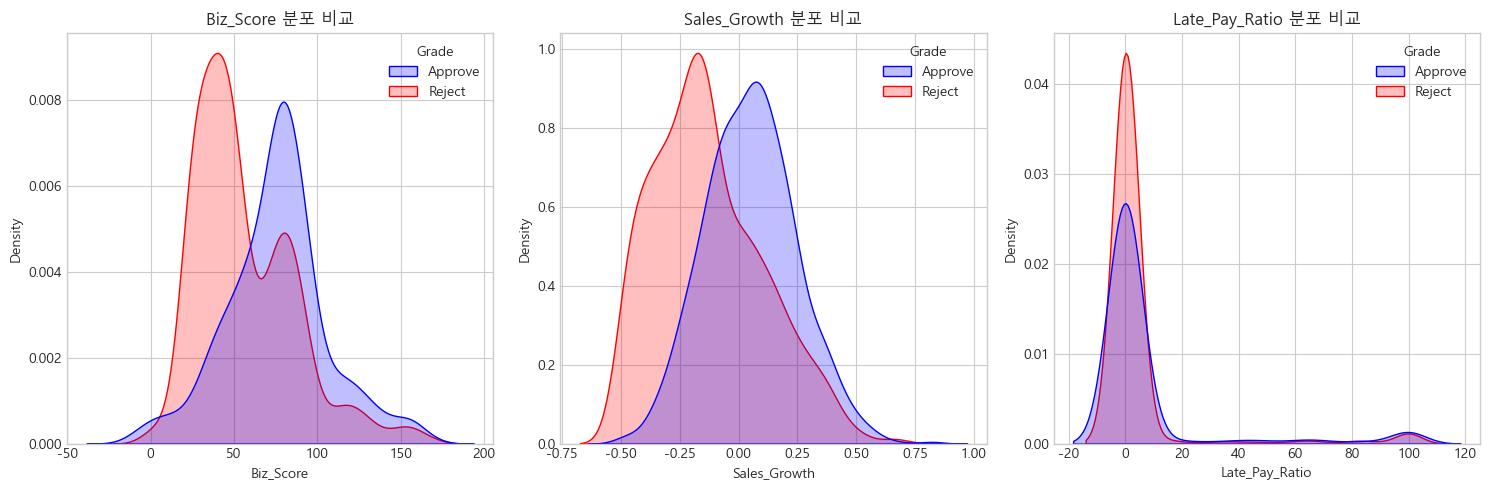

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("🚀 [M2] CTGAN 학습용 '씨앗(Seed)' 데이터 생성 시작...")

# 1. 정제된 승인 데이터 로드 (M1 결과물)
INPUT_FILE = 'Flow_Step1_Cleaned.csv'
if not os.path.exists(INPUT_FILE):
    print("❌ M1 단계 결과 파일(Flow_Step1_Cleaned.csv)이 없습니다.")
    exit()

df_real = pd.read_csv(INPUT_FILE)
df_real['Grade'] = 'Approve' # 명시적 라벨링

print(f"✅ 승인 데이터 로드: {len(df_real)}건")

# ------------------------------------------------------------------------------
# 2. 씨앗(Seed) 생성 로직: 심사역 기준 집중 공략
# ------------------------------------------------------------------------------
# CTGAN에게 "이게 바로 거절이야"라고 알려줄 명확한 예시를 만듭니다.

def generate_seed_rejects(real_df, n_samples):
    seeds = []
    
    # 승인 데이터에서 무작위로 샘플링하여 베이스로 사용 (현실성 확보)
    # -> 이렇게 하면 부채비율, 업종 특성 등은 유지되면서 핵심 지표만 나빠짐
    base_samples = real_df.sample(n=n_samples, replace=True).to_dict('records')
    
    for row in base_samples:
        new_row = row.copy()
        new_row['Grade'] = 'Reject'
        
        # [시나리오] 어떤 이유로 거절되었는가? (심사역 기준 3대장)
        # BIZ(신용), SALES(매출), LATE(태도) 중 하나 이상을 악화시킴
        scenario = np.random.choice(['BIZ', 'SALES', 'LATE', 'MULTI'], p=[0.3, 0.3, 0.2, 0.2])
        
        # 1. 기업 신용 불량 (Biz)
        if scenario in ['BIZ', 'MULTI']:
            new_row['Biz_Score'] = np.random.randint(20, 55) # D등급 이하
            # 연쇄 효과: 신용 나쁘면 금리 부담 -> 이익률 감소
            new_row['OPM_Change'] = -0.05 
            
        # 2. 매출 역성장 (Sales)
        if scenario in ['SALES', 'MULTI']:
            new_row['Sales_Growth'] = np.random.uniform(-0.5, -0.1) # -10% ~ -50%
            # 연쇄 효과: 매출 줄면 직원도 줄임
            new_row['Emp_Momentum'] = -0.1
            
        # 3. 결제 태도 불량 (Late)
        if scenario in ['LATE', 'MULTI']:
            new_row['Late_Pay_Ratio'] = np.random.uniform(0.3, 0.9) # 30% 이상
            new_row['Avg_Delay_Days'] = np.random.uniform(10, 60)   # 지연 발생
            new_row['Avg_Tx_Hour'] = np.random.uniform(16, 20)      # 늦은 결제

        # [노이즈] 나머지 변수들도 살짝 흔들어줌 (너무 똑같지 않게)
        new_row['Current_Ratio'] *= np.random.uniform(0.8, 1.1)
        new_row['Tx_Volatility'] = np.random.uniform(0.1, 0.5) # 거절 기업은 변동성이 좀 있는 편
        
        # 데이터 정합성 (음수 방지)
        new_row['Biz_Score'] = max(0, new_row['Biz_Score'])
        
        seeds.append(new_row)
        
    return pd.DataFrame(seeds)

# 씨앗 데이터 1,000개 생성 (학습용)
print("🌱 부실 기업 시나리오(Seed) 심는 중...")
df_seed = generate_seed_rejects(df_real, 1000)

# ------------------------------------------------------------------------------
# 3. 데이터 병합 및 확인
# ------------------------------------------------------------------------------
# Real(승인) + Seed(거절) -> CTGAN 학습용 데이터셋 완성
df_train_source = pd.concat([df_real, df_seed], ignore_index=True)

print(f"📊 학습 데이터셋 구성 완료: 총 {len(df_train_source)}건")
print(f"   - 승인(Approve): {len(df_real)}건")
print(f"   - 거절(Reject, Seed): {len(df_seed)}건")

# 시각화: 승인 vs 거절(Seed) 분포 차이 확인
# 우리가 의도한 대로 잘 갈라졌는지 확인
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
check_cols = ['Biz_Score', 'Sales_Growth', 'Late_Pay_Ratio']

for i, col in enumerate(check_cols):
    sns.kdeplot(data=df_train_source, x=col, hue='Grade', fill=True, ax=axes[i], palette={'Approve':'blue', 'Reject':'red'})
    axes[i].set_title(f'{col} 분포 비교')

plt.tight_layout()
plt.savefig('Step2_Seed_Check.png')
print("🖼️ 분포 확인 그래프 저장됨: Step2_Seed_Check.png")

# 저장
df_train_source.to_csv('Flow_Step2_Seed.csv', index=False)
print("\n✅ [M2 완료] CTGAN 학습용 데이터 저장됨: Flow_Step2_Seed.csv")
print("   -> 이제 이 파일을 가지고 CTGAN을 돌리면 됩니다!")

🚀 [M3] CTGAN 모델 학습 (불필요 컬럼 제거 버전)
✂️ 학습 제외 컬럼 삭제: ['Company_ID', 'Company_Name', 'Risk_Signals']
✅ 학습 데이터 최종 준비: 1846건 (컬럼 15개)
   -> 학습 변수: ['Grade', 'Late_Pay_Ratio', 'Avg_Delay_Days', 'Current_Ratio', 'Debt_Ratio', 'Biz_Score', 'CEO_Score', 'Tx_Count', 'Avg_Tx_Hour', 'Emp_Momentum', 'OPM_Change', 'Rev_Per_Emp', 'Sales_Growth', 'Tx_Volatility', 'Weekend_Tx_Ratio']

🧠 CTGAN 모델 학습 시작... (이제 경고 없이 진행됩니다)


Gen. (-1.92) | Discrim. (0.03): 100%|██████████| 300/300 [01:17<00:00,  3.87it/s] 


✅ 학습 완료! (소요시간: 79.7초)

🏭 AI가 데이터를 생성하는 중...


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


   -> 합성 승인 데이터 1,000건 생성


Sampling remaining columns: 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


   -> 합성 거절 데이터 1,500건 생성

📊 최종 마스터 데이터셋 완성: 총 1848건
🖼️ 품질 확인 그래프 저장됨: Step3_CTGAN_Check.png

✅ [M3 완료] 최종 학습용 데이터 저장됨: Flow_Training_Final_CTGAN.csv


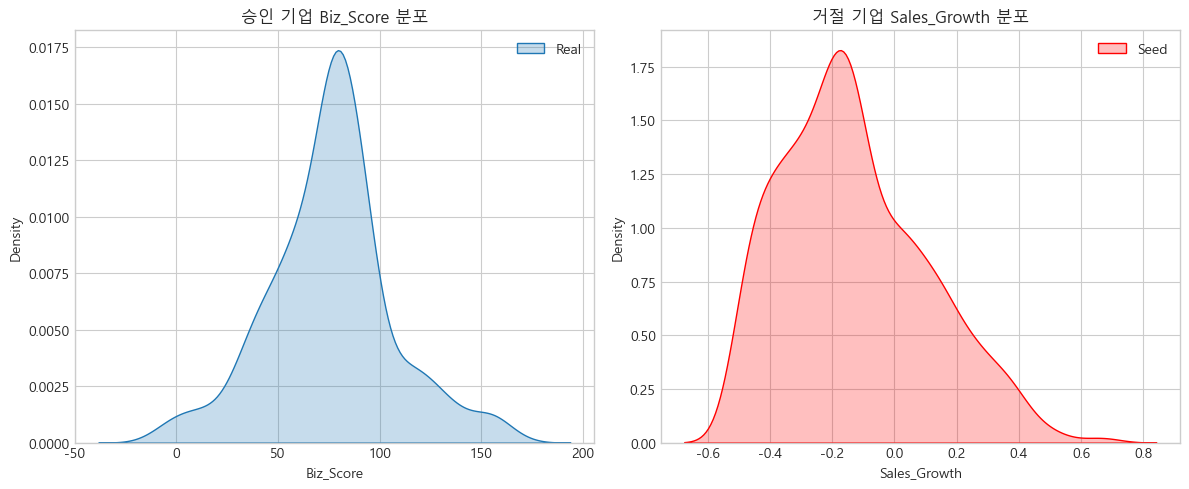

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings

# 경고 무시
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("🚀 [M3] CTGAN 모델 학습 (불필요 컬럼 제거 버전)")
print("=" * 60)

# 1. Seed 데이터 로드
INPUT_FILE = 'Flow_Step2_Seed.csv'
if not os.path.exists(INPUT_FILE):
    print("❌ M2 단계 결과 파일이 없습니다.")
    exit()

df_train = pd.read_csv(INPUT_FILE)

# 🚨 [핵심 수정] 학습 방해 컬럼 제거 (ID, 이름, 텍스트 등)
# AI는 오직 '숫자' 패턴만 학습해야 합니다.
drop_cols = ['Company_ID', 'Company_Name', 'Risk_Signals', 'Risk_Type', 'Company_Type']
# 실제로 데이터에 존재하는 컬럼만 골라서 삭제
cols_to_drop = [c for c in drop_cols if c in df_train.columns]

if cols_to_drop:
    print(f"✂️ 학습 제외 컬럼 삭제: {cols_to_drop}")
    df_train = df_train.drop(columns=cols_to_drop)

print(f"✅ 학습 데이터 최종 준비: {len(df_train)}건 (컬럼 {len(df_train.columns)}개)")
# 남은 컬럼 확인
print(f"   -> 학습 변수: {list(df_train.columns)}")

# ------------------------------------------------------------------------------
# 2. CTGAN 모델 설정 및 학습
# ------------------------------------------------------------------------------
try:
    from sdv.metadata import SingleTableMetadata
    from sdv.single_table import CTGANSynthesizer
    
    # 메타데이터 자동 감지
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_train)
    
    print("\n🧠 CTGAN 모델 학습 시작... (이제 경고 없이 진행됩니다)")
    
    # 모델 생성 (epochs=300)
    synthesizer = CTGANSynthesizer(metadata, epochs=300, verbose=True)
    
    start_time = time.time()
    synthesizer.fit(df_train)
    end_time = time.time()
    
    print(f"✅ 학습 완료! (소요시간: {end_time - start_time:.1f}초)")
    
    # --------------------------------------------------------------------------
    # 3. 데이터 증강 (Generation)
    # --------------------------------------------------------------------------
    print("\n🏭 AI가 데이터를 생성하는 중...")
    
    # (1) 승인 기업 증강
    cond_approve = pd.DataFrame({'Grade': ['Approve']})
    df_syn_approve = synthesizer.sample_remaining_columns(cond_approve, 1000)
    print(f"   -> 합성 승인 데이터 1,000건 생성")
    
    # (2) 거절 기업 증강
    cond_reject = pd.DataFrame({'Grade': ['Reject']})
    df_syn_reject = synthesizer.sample_remaining_columns(cond_reject, 1500)
    print(f"   -> 합성 거절 데이터 1,500건 생성")
    
    # --------------------------------------------------------------------------
    # 4. 데이터 병합 및 저장
    # --------------------------------------------------------------------------
    # 원본(Seed포함) + 합성 승인 + 합성 거절
    df_final = pd.concat([
        df_train,
        df_syn_approve,
        df_syn_reject
    ], ignore_index=True)
    
    print(f"\n📊 최종 마스터 데이터셋 완성: 총 {len(df_final)}건")
    
    # 시각화: Real vs Synthetic 분포 비교
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 승인 기업 비교
    sns.kdeplot(df_train[df_train['Grade']=='Approve']['Biz_Score'], label='Real', ax=axes[0], fill=True)
    sns.kdeplot(df_syn_approve['Biz_Score'], label='Synthetic(AI)', ax=axes[0], linestyle='--')
    axes[0].set_title('승인 기업 Biz_Score 분포')
    axes[0].legend()
    
    # 거절 기업 비교
    sns.kdeplot(df_train[df_train['Grade']=='Reject']['Sales_Growth'], label='Seed', ax=axes[1], fill=True, color='red')
    sns.kdeplot(df_syn_reject['Sales_Growth'], label='Synthetic(AI)', ax=axes[1], linestyle='--', color='orange')
    axes[1].set_title('거절 기업 Sales_Growth 분포')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('Step3_CTGAN_Check.png')
    print("🖼️ 품질 확인 그래프 저장됨: Step3_CTGAN_Check.png")
    
    # 저장
    df_final.to_csv('Flow_Training_Final_CTGAN.csv', index=False)
    print("\n✅ [M3 완료] 최종 학습용 데이터 저장됨: Flow_Training_Final_CTGAN.csv")

except ImportError:
    print("\n❌ SDV 라이브러리 오류.")
except Exception as e:
    print(f"\n❌ 오류 발생: {e}")